In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.linalg import det, inv

In [21]:

base_loras = ["zoom-in", "zoom-out"]
sub_loras = ["pan-left", "pan-right", "tilt-up", "tilt-down", "rolling-clockwise", "rolling-anticlockwise"]
blocks = list(range(5))
blocks

[0, 1, 2, 3, 4]

In [22]:
# 计算均值和协方差
def calculate_gaussian(data):
    # print(data.shape)
    mu = np.mean(data, axis=0)
    sigma = np.cov(data, rowvar=False)  # 协方差矩阵 (2,2)
    sigma += np.eye(9) * 1e-6
    return mu, sigma

In [23]:
def kl_divergence(mu1, sigma1, mu2, sigma2):
    """
    计算两个 9D 高斯分布的 KL 散度
    """
    sigma2_inv = inv(sigma2)  # 计算 Σ_Q 的逆
    trace_term = np.trace(sigma2_inv @ sigma1)  # Tr(Σ_Q^-1 * Σ_P)
    mean_diff = (mu2 - mu1).reshape(-1, 1)  # 变成列向量
    quadratic_term = mean_diff.T @ sigma2_inv @ mean_diff  # 二次项
    log_det_term = np.log(det(sigma2) / det(sigma1))  # 行列式比值的对数
    d = len(mu1)  # 维度 d=2

    return 0.5 * (trace_term + quadratic_term - d + log_det_term)

In [24]:
def generate():
    kl_distances = dict()
    for base in base_loras:

        lora_dlows_path = f"./DLOW/generated/{base}/reduced_camera_trajectory.npy"
        base_data = np.load(lora_dlows_path)
        base_mu, base_sigma = calculate_gaussian(base_data)

        for block in blocks:
            for sub in sub_loras:
                lora_dlows_path = f"./DLOW/generated/block{block}_{base}-{sub}/reduced_camera_trajectory.npy"
                data = np.load(lora_dlows_path)
                mu, sigma = calculate_gaussian(data)
            
                kl_value = kl_divergence(mu, sigma, base_mu, base_sigma)
                kl_distances[(base, sub, block)] = kl_value
    return kl_distances

In [25]:
kl_distances = generate()

# 创建表格（DataFrame）
rows = []
for i, base in enumerate(base_loras):
    for j, sub in enumerate(sub_loras):
        row = [base, sub] + [kl_distances[(base, sub, block)] for block in blocks]
        rows.append(row)

columns = ["Base LoRA", "Sub LoRA"] + blocks
df = pd.DataFrame(rows, columns=columns)

# 打印表格
print(df)

   Base LoRA               Sub LoRA                       0  \
0    zoom-in               pan-left  [[0.7719070751971634]]   
1    zoom-in              pan-right  [[2.5151642084873074]]   
2    zoom-in                tilt-up  [[1.4893105113328498]]   
3    zoom-in              tilt-down  [[2.6870340734235048]]   
4    zoom-in      rolling-clockwise  [[0.5682786820386846]]   
5    zoom-in  rolling-anticlockwise  [[1.0174928165127985]]   
6   zoom-out               pan-left  [[1.3384089327216435]]   
7   zoom-out              pan-right   [[1.486834315807712]]   
8   zoom-out                tilt-up  [[3.8976635185391606]]   
9   zoom-out              tilt-down  [[2.0453343438262697]]   
10  zoom-out      rolling-clockwise   [[0.618765157303864]]   
11  zoom-out  rolling-anticlockwise  [[1.0870325714076512]]   

                         1                        2                       3  \
0    [[2.327522185575375]]   [[0.8557823279868129]]  [[1.5184154105644843]]   
1    [[2.5935035400037

/tmp/ipykernel_746023/1248270303.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sns.heatmap(df_numeric, annot=True, cmap="coolwarm", xticklabels=blocks, yticklabels=df[["Base LoRA", "Sub LoRA"]].apply(lambda x: f"{x[0]}-{x[1]}", axis=1))


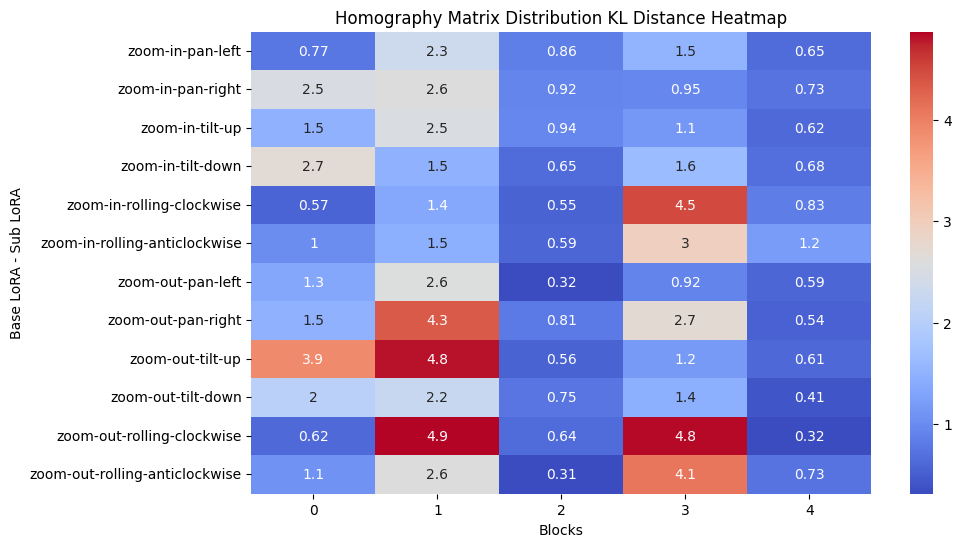

In [27]:
# 绘制热力图
plt.figure(figsize=(10, 6))
df_numeric = df.drop(columns=["Base LoRA", "Sub LoRA"]).astype(float)
sns.heatmap(df_numeric, annot=True, cmap="coolwarm", xticklabels=blocks, yticklabels=df[["Base LoRA", "Sub LoRA"]].apply(lambda x: f"{x[0]}-{x[1]}", axis=1))
plt.title("Homography Matrix Distribution KL Distance Heatmap")
plt.xlabel("Blocks")
plt.ylabel("Base LoRA - Sub LoRA")
plt.show()